In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self,data, _children=(), _op = "", _label = "") -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._label = _label

        self.grad = 0.0 # no effect defualt that gradadient does not affect  # this represents derivative of output (L) with respect to this node
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),"*")

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self,other):
      assert isinstance(other, (int, float)), "only supporting int/float powers"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
        self.grad += other*(self.data**(other-1)) * out.grad
      out._backward = _backward

      return out

    def __rmul__(self,other): # other + self
        return self * other

    def __truediv__(self, other):
      return self * other**-1 # self/other

    def __neg__(self):
      return self * -1

    def __sub__(self,other): #self - other
      return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward(): #1 - o**2
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self,), 'exp')

      def _backward():
          self.grad += out.data * out.grad
      out._backward = _backward

      return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
              visited.add(v)
              for child in v._prev:
                build_topo(child)
              topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo): node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
b / a

Value(data=2.0)

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    print(edges)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data %.4f | grad %0.4f}" % (n._label, n.data,n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op,label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
a = Value(2.0,_label="a")
b = Value(-3.0,_label="b")
c = Value(10.0,_label="c")
e = a*b; e._label = 'e'
d = e + c; d._label = 'd'
f = Value(-2.0, _label ='f')
L = d*f
L._label = 'L '
d

Value(data=4.0)

{(Value(data=4.0), Value(data=-8.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=-2.0), Value(data=-8.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=10.0), Value(data=4.0)), (Value(data=2.0), Value(data=-6.0))}


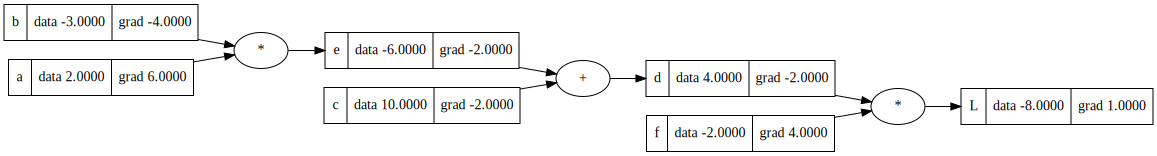

In [ ]:
draw_dot(L) #forward pass

backpropagation now
derivative of l with respect to all the leaf nodes and not the input


L here is a loss function now, weights == leaf nodes -> how weights impact loss function

In [ ]:
L = d * f

dl/dd = ?
(f(x+h)-f(x))/h

(d+h)*f - d*f)/h
d*f + h*f - d*f = hf/h = f

In [ ]:
# most important
dl/dc

dd/dc

d = c + e

(f(x+h)-f(x))/h

c + h + e  - (c+e) = c+ h + e - c + e -> h/h = 1.0

dd/dc = 1.0 # local differencial
dd/de = 1.0


dl/dc = dl/dd * dd/dc =

In [ ]:
dl/de = -2.0

we want
dl/da = dl/de * de/da

e = a*b
de /da = b


In [ ]:
L.grad = 1
f.grad = 4.0
d.grad = -2
c.grad =  d.grad*1
e.grad = d.grad*1

a.grad = e.grad*-3.00
b.grad = e.grad*2

In [ ]:
def cal_grad():
  h = 0.001
  a = Value(2.0,_label="a")
  b = Value(-3.0,_label="b")
  c = Value(10.0,_label="c")
  e = a*b; e._label = 'e'
  d = e + c; d._label = 'd'
  f = Value(-2.0, _label ='f')
  L = d*f;L._label = 'L'
  L1 = L.data

  a = Value(2.0,_label="a")
  b = Value(-3.0,_label="b")
  c = Value(10.0,_label="c")
  c.data+=h
  e = a*b; e._label = 'e'
  d = e + c; d._label = 'd'
  f = Value(-2.0, _label ='f')
  L = d*f; L._label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

cal_grad()


-1.9999999999988916


backpropagation inside a neuron

In [ ]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'

b = Value(6.8813735870195432, _label='b')

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'

In [ ]:
o.grad = 1.0
n.grad = 1.0 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = n.grad
x1w1.grad = n.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad


In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

x1w1 = x1*w1
do/dx1 = dx1w1/dx1 * do/dxw1

do/dxw1 = 0.6347


x1+h*w1 - x1w1 / h = x1w1 + w1*h1 - x1w1 = w1h1/h1 = w1*do/dxw1

{(Value(data=-6.0), Value(data=-6.0)), (Value(data=6.7), Value(data=0.7000000000000002)), (Value(data=0.7000000000000002), Value(data=0.6043677771171636)), (Value(data=-6.0), Value(data=0.7000000000000002)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=1.0), Value(data=0.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=2.0), Value(data=-6.0))}


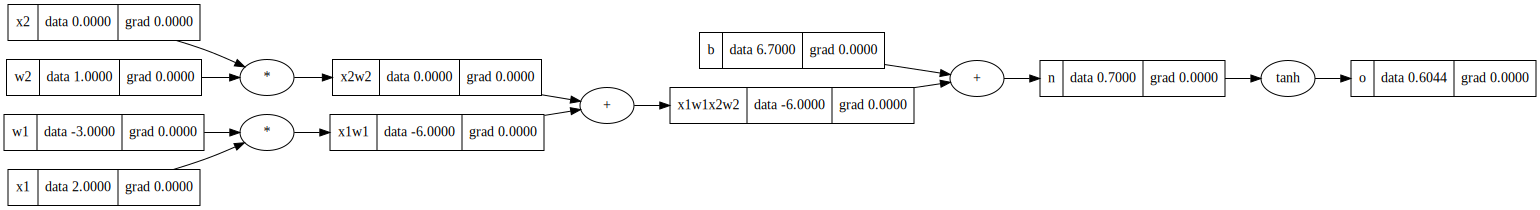

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
x2._backward()

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)

for node in reversed(topo): node._backward()


In [ ]:
o.backward()

{(Value(data=0.8813735870195432), Value(data=0.7071067811865476)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=1.0), Value(data=0.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=-3.0), Value(data=-6.0))}


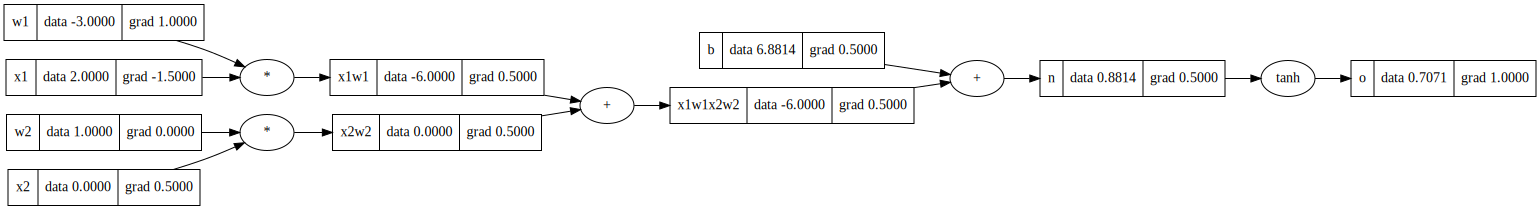

In [ ]:
draw_dot(o)

{(Value(data=3.0), Value(data=6.0))}


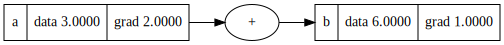

In [ ]:
a = Value(3.0, _label='a')
b = a + a; b._label='b'
b.backward()
draw_dot(b)

In [ ]:
b.backward()

In [ ]:
a + 1

Value(data=4.0)

In [ ]:
2* a

Value(data=6.0)

In [ ]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'

b = Value(6.8813735870195432, _label='b')

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'

e = (2*n).exp()
o = (e- 1) / (e + 1)


#o = n.tanh();
o._label = 'o'

o.backward()

{(Value(data=0.0), Value(data=0.0)), (Value(data=4.828427124746192), Value(data=0.7071067811865477)), (Value(data=0.1464466094067262), Value(data=0.7071067811865477)), (Value(data=1.7627471740390863), Value(data=5.828427124746192)), (Value(data=0.8813735870195432), Value(data=1.7627471740390863)), (Value(data=2), Value(data=1.7627471740390863)), (Value(data=2.0), Value(data=-6.0)), (Value(data=6.828427124746192), Value(data=0.1464466094067262)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=-1), Value(data=4.828427124746192)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=5.828427124746192), Value(data=4.828427124746192)), (Value(data=5.828427124746192), Value(data=6.828427124746192)), (Value(data=1.0), Value(data=0.0)), (Value(data=1), Value(data=6.828427124746192))}


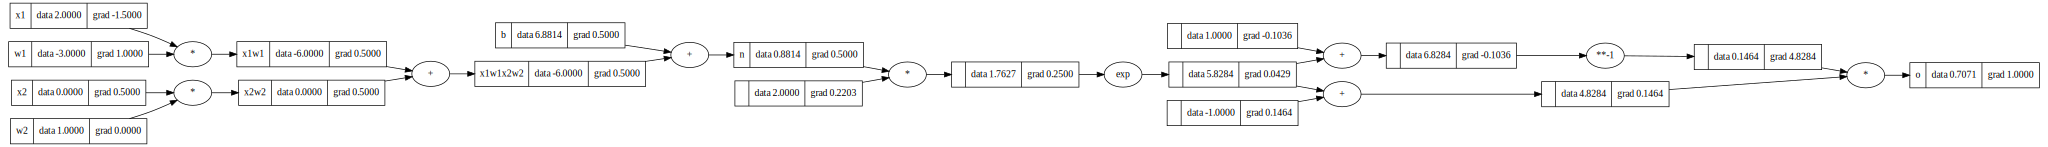

In [ ]:
draw_dot(o)

**working with torch**

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []

    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers: x = layer(x)

    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.9783011677192919)

In [ ]:
len(n.parameters())

41

{(Value(data=0.8366953679450206), Value(data=0.28481236494995443)), (Value(data=0.9906036551472802), Value(data=0.9570762151298057)), (Value(data=0.3112018699300002), Value(data=0.49555323850560273)), (Value(data=-0.1700115078783513), Value(data=0.48530078919204156)), (Value(data=0.04949336993551845), Value(data=-0.5499923655040442)), (Value(data=2.0), Value(data=-1.7734774352856557)), (Value(data=0.14716073159792575), Value(data=0.2943214631958515)), (Value(data=0.3673113471317131), Value(data=-0.5442718281083376)), (Value(data=0.585144825046692), Value(data=-0.5197869009415924)), (Value(data=1.200336141110477), Value(data=1.724856796225003)), (Value(data=0.09970279955635863), Value(data=0.05118404620883745)), (Value(data=-0.3854391721049415), Value(data=-0.770878344209883)), (Value(data=0.05118404620883745), Value(data=1.7279740410934081)), (Value(data=-0.40017392769847593), Value(data=-0.39924809133501943)), (Value(data=0.3191088569073885), Value(data=-1.5179146166455153)), (Value(d

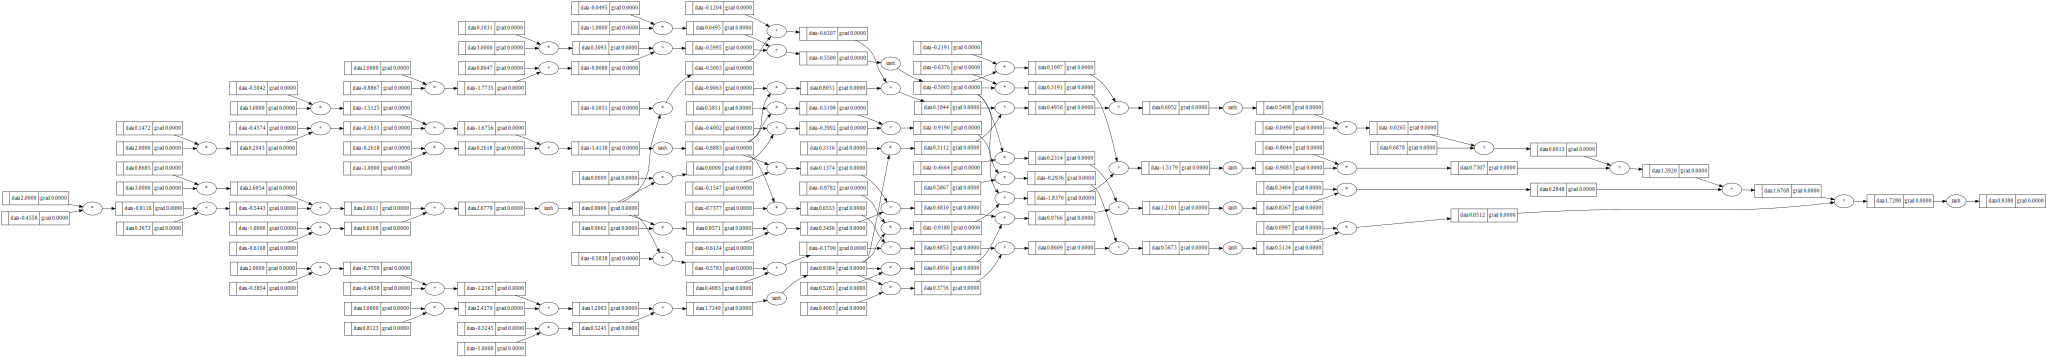

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.9783011677192919),
 Value(data=0.7633063530413098),
 Value(data=0.9746716310373805),
 Value(data=0.870268022848909)]

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))#mse
loss

Value(data=6.552470948941119)

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))#mse
loss

Value(data=6.405714217691994)

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

-0.38773329289314556

In [ ]:
n.layers[0].neurons[0].w[0].data

-0.5396199160024089

In [ ]:
for p in n.parameters():
  p.data+= -0.01*p.grad

In [ ]:
n.layers[0].neurons[0].w[0].data

-0.5357425830734774

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))#mse
loss

Value(data=0.012450341968040894)

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
  p.data+= -0.01*p.grad

In [ ]:
 [n(x) for x in xs]

[Value(data=0.9830892671592163),
 Value(data=-0.9941345264688695),
 Value(data=-0.9887074413985512),
 Value(data=0.9005367826797178)]

In [ ]:
loss_arr = [ ]
for k in range(1000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.001 * p.grad

  print(k, loss.data)
  loss_arr.append(loss.data)


0 7.02587857031755
1 6.985475028289913
2 6.943171850785056
3 6.898967603754232
4 6.852878197867387
5 6.804938696923227
6 6.755204848652958
7 6.703754236301576
8 6.650686953785981
9 6.5961257190850215
10 6.5402153599707376
11 6.4831216326262755
12 6.425029365689323
13 6.366139957655578
14 6.306668291680335
15 6.246839165672479
16 6.18688336429825
17 6.1270335206177
18 6.067519926767552
19 6.008566454471304
20 5.950386737266718
21 5.893180748202007
22 5.837131881171937
23 5.782404613416468
24 5.729142793639582
25 5.677468567359573
26 5.627481920824823
27 5.579260798979684
28 5.532861732788494
29 5.488320897316119
30 5.445655514309912
31 5.404865511118795
32 5.365935350749256
33 5.3288359546165855
34 5.293526648957087
35 5.259957076827043
36 5.228069029162611
37 5.197798159727856
38 5.169075559351748
39 5.1418291742585405
40 5.115985061312067
41 5.091468479546685
42 5.068204822478118
43 5.046120399483216
44 5.025143077162242
45 5.005202793226903
46 4.986231956272961
47 4.9681657449711
48 

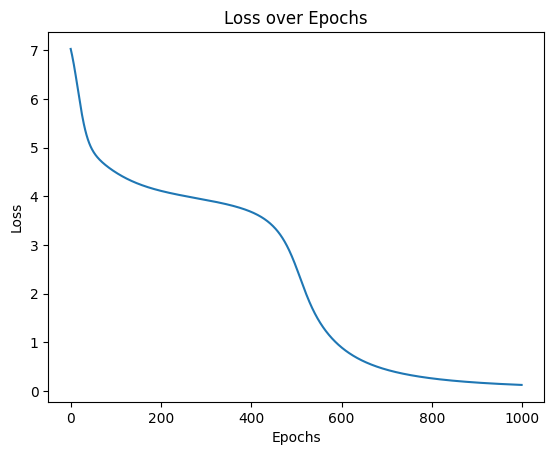

In [ ]:
x_values = np.arange(0, 1000)

# Create the plot
plt.plot(x_values, loss_arr)

# Label the axes
plt.xlabel('Epochs')  # Change this to your x-axis label
plt.ylabel('Loss')    # Change this to your y-axis label

# Title of the plot
plt.title('Loss over Epochs')

# Show the plot
plt.show()